# Mambaca dataset yang sudah dinormalisasi

In [1]:
import pandas as pd

df = pd.read_csv('normalisasi.csv')

In [2]:
# Mengubah nama kolom 'url_asli' menjadi 'url'
df.rename(columns={'url_asli': 'url'}, inplace=True)
df = df.reindex(['url', 'status'], axis=1)
df.head(787)

,url,status
0,https://www.facebook.com/photo/?fbid=233400553...,Legitimate
1,http://zabgc.ru/file/Plan/Santander/Particular...,Phishing
2,https://www.babla.co.id/bahasa-inggris-bahasa-...,Legitimate
3,https://xplusstore.com/cig-bin/lt/3mail@b.c,Phishing
4,https://www.facebook.com/photo?fbid=2381004508...,Legitimate
...,...,...
781,http://139.59.1.191/nexus/wp-includes/o/Liinke...,Phishing
782,https://e-meterai.co.id/,Legitimate
783,https://bit.ly/facebo0k-login,Phishing
784,https://windows365.microsoft.com/spa-signin-oidc,Legitimate


In [3]:
df.describe()

,url,status
count,786,786
unique,786,2
top,https://www.facebook.com/photo/?fbid=233400553...,Legitimate
freq,1,393


# Melakukan visualisasi distribusi kategori status

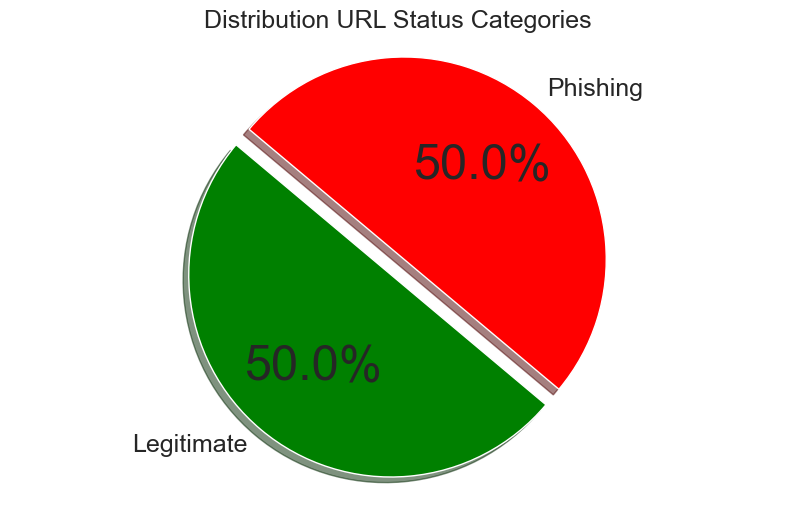

In [23]:
import matplotlib.pyplot as plt

# Assuming you have a pandas DataFrame 'df'
status_counts = df['status'].value_counts()
total = status_counts.sum()

# Calculate percentage
percentages = status_counts / total

# Define your specific colors for 'legitimate' and 'phishing'.
# If there are other categories, they will be colored gray.
colors = ['green' if label == 'Legitimate' else 'red' if label == 'Phishing' else 'white' for label in status_counts.index]

# Create an "explode" array to highlight a slice, here we highlight the first slice
explode = [0.1 if i == 0 else 0 for i in range(len(percentages))]

# Define autopct lambda function with increased font size
def make_autopct(values):
    def my_autopct(pct):
        return ('%1.1f%%' % pct) if pct > 0 else ''
    return my_autopct

fig, ax = plt.subplots(figsize=(10, 6))
patches, texts, autotexts = ax.pie(percentages, labels=status_counts.index, colors=colors,
                                   autopct=make_autopct(percentages), startangle=140, shadow=True, explode=explode, textprops={'fontsize': 18})

# Increase font size of the percentage labels
for autotext in autotexts:
    autotext.set_fontsize(35)

# Equal aspect ratio ensures that pie is drawn as a circle.
ax.axis('equal')

ax.set_title('Distribution URL Status Categories', fontsize=18)
plt.show()


# Melakukan ekstraksi fitur

In [5]:
from urllib.parse import urlparse
from unidecode import unidecode
from bs4 import BeautifulSoup
import requests
import openai
import whois
import time
import re


# menghitung panjang domain
def length_domain(url):
    parsed_url = urlparse(url)
    domain_parts = parsed_url.netloc.split('.')

    if parsed_url.netloc.replace('.', '').isnumeric():
        return -1

    if len(domain_parts) >= 2:
        last_part = domain_parts[-1]
        second_last_part = domain_parts[-2]
        if len(last_part) <= 3 and len(second_last_part) <= 3:
            domain_parts = domain_parts[:-2]
        elif len(last_part) <= 3:
            domain_parts = domain_parts[:-1]

    main_domain = domain_parts[-1] if len(domain_parts) >= 1 else ''

    domain_length = len(main_domain)
    if domain_length > 10:
        result_length = -1
    else:
        result_length = 1

    return result_length

# Memeriksa apakah domain memiliki tanda hubung (-)
def dashes(url):
    parsed_url = urlparse(url)
    domain_parts = parsed_url.netloc.split('.')

    if parsed_url.netloc.replace('.', '').isnumeric():
        return -1

    if len(domain_parts) >= 2:
        last_part = domain_parts[-1]
        second_last_part = domain_parts[-2]
        if len(last_part) <= 3 and len(second_last_part) <= 3:
            domain_parts = domain_parts[:-2]
        elif len(last_part) <= 3:
            domain_parts = domain_parts[:-1]

    main_domain = domain_parts[-1] if len(domain_parts) >= 1 else ''

    if '-' in main_domain:
        return -1
    return 1


# Memeriksa apakah url memiliki protocol http atau https
def check_ssl(url):
    parsed_url = urlparse(url)
    scheme = parsed_url.scheme

    if parsed_url.netloc.replace('.', '').isnumeric():
        return -1

    if scheme == 'https':
        return 1
    else:
        return -1


# Memeriksa penggunaan tld (top level domain) yang di perbolehkan
def tld(url):
    parsed_url = urlparse(url)

    if parsed_url.netloc.replace('.', '').isnumeric():
        return -1

    match = re.search(r'(?<=://)[\w\.-]+', url)
    if match:
        domain = match.group(0)
        has_number = any(char.isdigit() for char in domain)
        if has_number:
            return -1

    valid_domains = ["com", "io", "gov", "org", "net", "ac.id", "edu", "co.id", "id",
                     "go.id", "mil.id", "sch.id", "or.id", "net.id"]

    domain = parsed_url.netloc.split('.')[-1]
    if domain in valid_domains:
        return 1
    else:
        return -1

# Memeriksa penggunaan karakter yang dilarang
def check_prohibited_characters(url):

    parsed_url = urlparse(url)
    if parsed_url.netloc.replace('.', '').isnumeric():
        return -1

    if '@' in url or '!' in url or ';'  in url or '*' in url:
        return -1
    else:
        return 1

# Memeriksa panjang karakter spesial yang diperbolehkan
def length_special_characters(url):

    parsed_url = urlparse(url)
    if parsed_url.netloc.replace('.', '').isnumeric():
        return -1

    path = url.split('/', 3)[-1]
    special_chars = {'#', '+', '?', '-', '_', '=', '$', '%', '&'}

    count = sum(1 for char in path if char in special_chars)
    if count < 15 :
        return 1
    else:
        return -1

# memeriksa banyak path yang digunakan
def check_path(url):

    parsed_url = urlparse(url)
    path = parsed_url.path

    if parsed_url.netloc.replace('.', '').isnumeric():
        return -1

    jumlah_path = path.count('/')

    if jumlah_path <= 3:
        return 1
    else:
        return -1

# Memeriksa banyak single slash yang digunakan
def count_single_slash(url):

    parsed_url = urlparse(url)
    if parsed_url.netloc.replace('.', '').isnumeric():
        return -1

    single_slash_count = url.count('/') - url.count('//')
    if single_slash_count > 4:
        return -1
    else:
        return 1

# Memeriksa banyak titik yang digunakan dengen batas maksimal 5
def count_dots(url):

    parsed_url = urlparse(url)
    if parsed_url.netloc.replace('.', '').isnumeric():
        return -1

    dot_count = url.count('.')
    if dot_count > 5:
        return -1
    else:
        return 1

# memeriksa panjang url yang digunakan dengan batas maksimal 80 karakter
def length_url(url):

    parsed_url = urlparse(url)
    if parsed_url.netloc.replace('.', '').isnumeric():
        return -1

    if len(url) > 80:
        return -1
    else:
        return 1

# memeriksa sumbers daya konten yang digunakan mengandung kata yang mencurigakan
def sumber_daya_konten(url):
    try:
        response = requests.get(url)

        soup = BeautifulSoup(response.text, 'html.parser')

        text = ' '.join(soup.stripped_strings).lower()

        normalized_text = unidecode(text)

        if re.search(r'\b(claim|reward|ambil|hadiahmu|kepo|kepoin|melihat|stalking|ngepoin|fb|ig|tarif|dana|facebookkepo)\b', normalized_text):
            return -1
        else:
            return 1
    except requests.exceptions.RequestException as e:
        return 1

# memeriksa keberadaan favicon
def keberadaan_favicon(url):
    try:
        response = requests.get(url)
        soup = BeautifulSoup(response.content, 'html.parser')
        head = soup.find('head')
        if head:
            favicon_links = head.find_all('link', rel='icon')
            for favicon_link in favicon_links:
                href = favicon_link.get('href')
                if href.endswith('.ico') or href.endswith('.png'):
                    return 1
        return -1
    except requests.exceptions.RequestException as e:
        return -1

# Memeriksa whois domain yang digunakan apakah memiliki status atau tidak
def check_whois(url):
    parsed_url = urlparse(url)

    try:
        domain = whois.whois(parsed_url.netloc)
        if domain.status:
            return 1
        else:
            return -1
    except Exception as e:
        print("Error saat memeriksa whois, Nilai dikembalikan menjadi -1:", e)
        return -1

# mengggunakan model openai untuk memeriksa url yang digunakan apakah phishing atau tidak
def openai_model_text_davinci_003(url):
    counter = 0
    while True:
        counter += 1
        try:
            openai.api_key = ''
            command = f"Periksa URL ini merupakan phishing atau tidak. Jika phishing berikan nilai output -1, dan jika tidak phishing berikan nilai 1. result hanya berupa angka 1 dan -1 tidak perlu memiliki penjelasan deskripsi. '{url}'"

            response = openai.Completion.create(
                model="text-davinci-003",
                prompt=command,
                temperature=1,
                max_tokens=5,
                top_p=1,
                frequency_penalty=0,
                presence_penalty=0
            )
            result = response.choices[0].text.strip()


            if result == "1":
                return 1
            elif result == "-1":
                return -1

            print(f"Hasil model text-davinci-003 tidak valid pada percobaan ke-{counter}, mencoba kembali...")
        except Exception as e:
            print(f"Terjadi kesalahan pada model text-davinci-003 pada percobaan ke-{counter}:", str(e))
            print("Akan mencoba kembali setelah 5 detik...")
            time.sleep(5)


# Mengganti status Legitimate dan Phishing menjadi 1 dan -1
df['status'] = df['status'].apply(lambda x: 1 if x == 'Legitimate' else (-1 if x == 'Phishing' else x))

# membungkus dan memanggil fungsi ekstraksi fitur yang telah dibuat ke dalam dataframe
df['panjang_domain'] = df['url'].apply(length_domain)
df['tanda_penghubung_domain'] = df['url'].apply(dashes)
df['penggunaan_ssl'] = df['url'].apply(check_ssl)
df['domain_tld'] = df['url'].apply(tld)
df['penggunaan_karakter_dilarang'] = df['url'].apply(check_prohibited_characters)
df['panjang_karakter_spesial'] = df['url'].apply(length_special_characters)
df['batas_path'] = df['url'].apply(check_path)
df['banyak_single_slash'] = df['url'].apply(count_single_slash)
df['banyak_titik'] = df['url'].apply(count_dots)
df['panjang_URL'] = df['url'].apply(length_url)
df['isi_konten'] = df['url'].apply(sumber_daya_konten)
df['favicon'] = df['url'].apply(keberadaan_favicon)
df['cek_whois'] = df['url'].apply(check_whois)
df['openai_text_davinci_003'] = df['url'].apply(openai_model_text_davinci_003)

C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\bs4\builder\__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\bs4\builder\__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse t

Error saat memeriksa whois, Nilai dikembalikan menjadi -1: No match for "INTERRNET-DIGIITAL-LOGIIN.COM".
>>> Last update of whois database: 2023-06-12T17:58:15Z <<<

NOTICE: The expiration date displayed in this record is the date the
registrar's sponsorship of the domain name registration in the registry is
currently set to expire. This date does not necessarily reflect the expiration
date of the domain name registrant's agreement with the sponsoring
registrar.  Users may consult the sponsoring registrar's Whois database to
view the registrar's reported date of expiration for this registration.

TERMS OF USE: You are not authorized to access or query our Whois
database through the use of electronic processes that are high-volume and
automated except as reasonably necessary to register domain names or
modify existing registrations; the Data in VeriSign Global Registry
Services' ("VeriSign") Whois database is provided by VeriSign for
information purposes only, and to assist persons in o

In [6]:
df.head()

,url,status,panjang_domain,tanda_penghubung_domain,penggunaan_ssl,domain_tld,penggunaan_karakter_dilarang,panjang_karakter_spesial,batas_path,banyak_single_slash,banyak_titik,panjang_URL,isi_konten,favicon,cek_whois,openai_text_davinci_003
0,https://www.facebook.com/photo/?fbid=233400553...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,http://zabgc.ru/file/Plan/Santander/Particular...,-1,1,1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1
2,https://www.babla.co.id/bahasa-inggris-bahasa-...,1,1,1,1,1,1,1,1,1,1,1,1,-1,1,1
3,https://xplusstore.com/cig-bin/lt/3mail@b.c,-1,1,1,1,1,-1,1,1,1,1,1,1,-1,1,-1
4,https://www.facebook.com/photo?fbid=2381004508...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [7]:
# Simpan dataframe hasilnya ke file lain
df.to_csv('ektrak_fitur.csv', index=False)